# Fraud Detection Case Study
This notebook used AI to restructure and beautify the code of fraud.ipynb (found in `notebooks/`) without changing its functionality



## Setup and Data Loading

- Load `data/fraud.csv`
- Normalize string columns (`customer`, `age`, `gender`, `zipcodeOri`, `merchant`, `zipMerchant`, `category`)
- Keep raw `df` for EDA, then proceed to cleaning and encoding


In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    average_precision_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Gradient boosting
import lightgbm as lgb

# Explainability
import shap

# Persistence
import joblib


# Load data
DATA_PATH = 'data/fraud.csv'
df = pd.read_csv(DATA_PATH)

# Normalize string columns
string_cols = ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip().str.strip("'").str.strip('"')

print('Shape:', df.shape)
df.head()


Shape: (594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


## Exploratory Data Analysis (EDA)

- Class distribution and imbalance check
- Transaction amount distribution and outliers
- Boxplots by fraud class
- Temporal fraud rate trend over `step`
- Fraud rate by `category`, `age`, and `gender`


Fraud value counts:
 fraud
0    587443
1      7200
Name: count, dtype: int64

Fraud class distribution (%):
 fraud
0    98.789189
1     1.210811
Name: proportion, dtype: float64


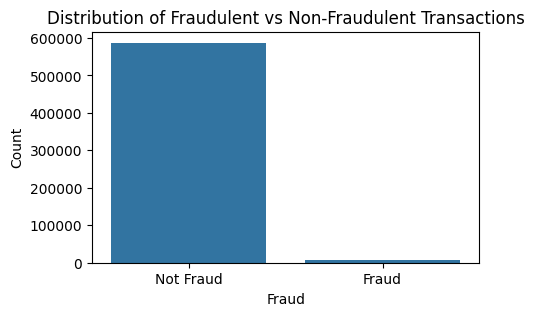

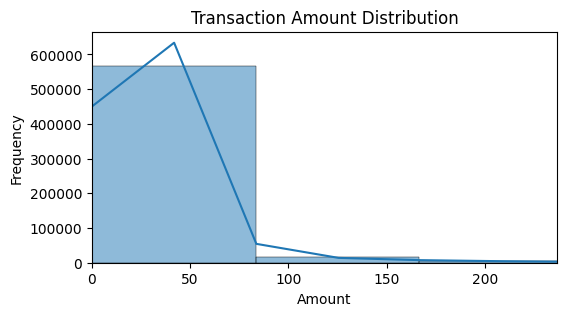

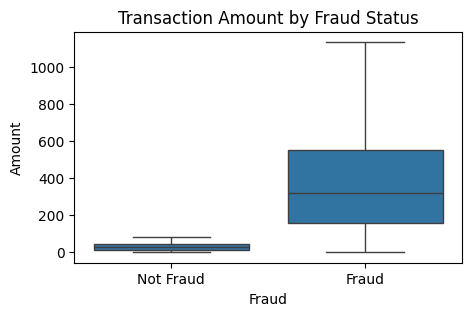

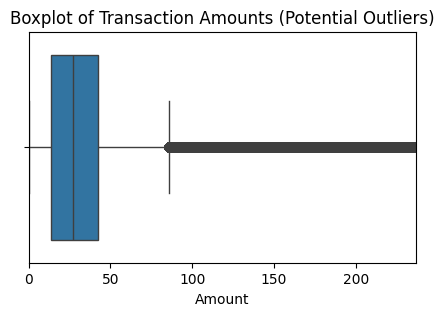

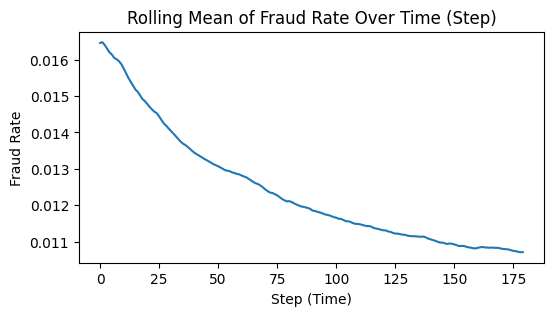

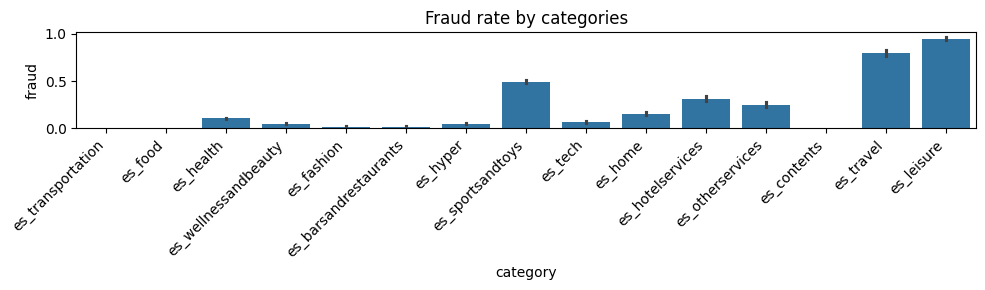

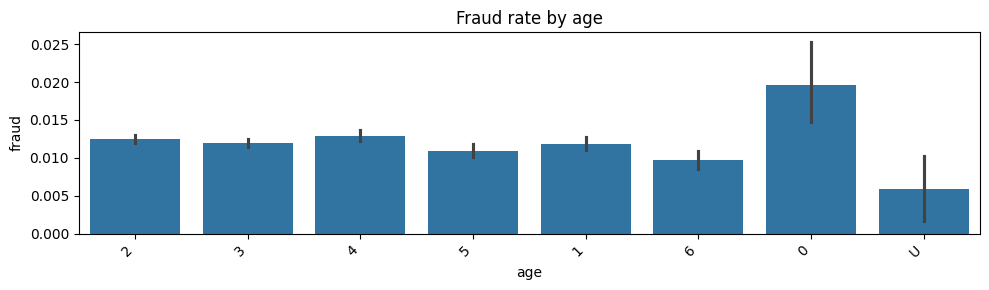

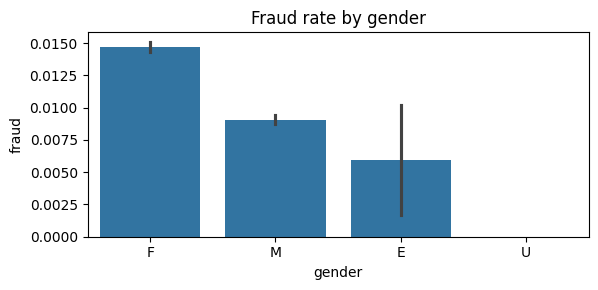

In [2]:
# Class distribution
fraud_counts = df['fraud'].value_counts()
fraud_percent = df['fraud'].value_counts(normalize=True) * 100
print("Fraud value counts:\n", fraud_counts)
print("\nFraud class distribution (%):\n", fraud_percent)

plt.figure(figsize=(5, 3))
sns.countplot(x='fraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()

# Amount distribution and outliers
plt.figure(figsize=(6, 3))
sns.histplot(df['amount'], bins=100, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, df['amount'].quantile(0.99))
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x='fraud', y='amount', data=df, showfliers=False)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Amount')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x=df['amount'])
plt.title('Boxplot of Transaction Amounts (Potential Outliers)')
plt.xlabel('Amount')
plt.xlim(0, df['amount'].quantile(0.99))
plt.show()

# Temporal rolling fraud rate
fraud_by_step = df.groupby('step')['fraud'].mean()
fraud_by_step.rolling(window=10, min_periods=1).mean().plot(figsize=(6, 3))
plt.title('Rolling Mean of Fraud Rate Over Time (Step)')
plt.xlabel('Step (Time)')
plt.ylabel('Fraud Rate')
plt.show()

# Fraud rate by categories
plt.figure(figsize=(10, 3))
order = df['category'].value_counts().index
sns.barplot(x='category', y='fraud', data=df, order=order, estimator=np.mean)
plt.xticks(rotation=45, ha='right')
plt.title('Fraud rate by categories')
plt.tight_layout()
plt.show()

# Fraud rate by age
plt.figure(figsize=(10, 3))
order = df['age'].value_counts().index
sns.barplot(x='age', y='fraud', data=df, order=order, estimator=np.mean)
plt.xticks(rotation=45, ha='right')
plt.title('Fraud rate by age')
plt.tight_layout()
plt.show()

# Fraud rate by gender
plt.figure(figsize=(6, 3))
order = df['gender'].value_counts().index
sns.barplot(x='gender', y='fraud', data=df, order=order, estimator=np.mean)
plt.xticks(rotation=0)
plt.title('Fraud rate by gender')
plt.tight_layout()
plt.show()


## Preprocessing and Encoding

- Drop (`zipcodeOri`, `zipMerchant`) because they have a single unique value (0 variance)
- Replace unknown `age == 'U'` with placeholder `'ent'` (age is unkown to rows with gender == E)
- One-hot encode `age`, `gender`, `category`, `merchant` 
- Produce `df_basic` for baseline models


In [3]:
# Create a baseline, encoded dataframe for initial models

df_basic = df.copy()

# Drop zipcode columns
for col in ['zipcodeOri', 'zipMerchant']:
    if col in df_basic.columns:
        df_basic = df_basic.drop(columns=[col])

# Replace unknown age
if 'age' in df_basic.columns:
    df_basic['age'] = df_basic['age'].replace('U', 'ent')

# One-hot encode selected categoricals (keep 'merchant' column for later aggregates)
cat_cols = ['age', 'gender', 'category', 'merchant']
for col in cat_cols:
    if col in df_basic.columns:
        dummies = pd.get_dummies(df_basic[col], prefix=col, dtype='uint8')
        if col == 'merchant':
            df_basic = pd.concat([df_basic, dummies], axis=1)
        else:
            df_basic = pd.concat([df_basic.drop(columns=[col]), dummies], axis=1)

print('df_basic shape:', df_basic.shape)
df_basic.head()


df_basic shape: (594643, 82)


,step,customer,merchant,amount,fraud,age_0,age_1,age_2,age_3,age_4,...,merchant_M732195782,merchant_M78078399,merchant_M840466850,merchant_M855959430,merchant_M857378720,merchant_M85975013,merchant_M923029380,merchant_M933210764,merchant_M97925176,merchant_M980657600
0,0,C1093826151,M348934600,4.55,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,C352968107,M348934600,39.68,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,C2054744914,M1823072687,26.89,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,C1760612790,M348934600,17.25,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,C757503768,M348934600,35.72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Correlation with Target (`fraud`)

- Keep only numeric columns with variance
- Compute correlation with `fraud`
- Plot sorted heatmap


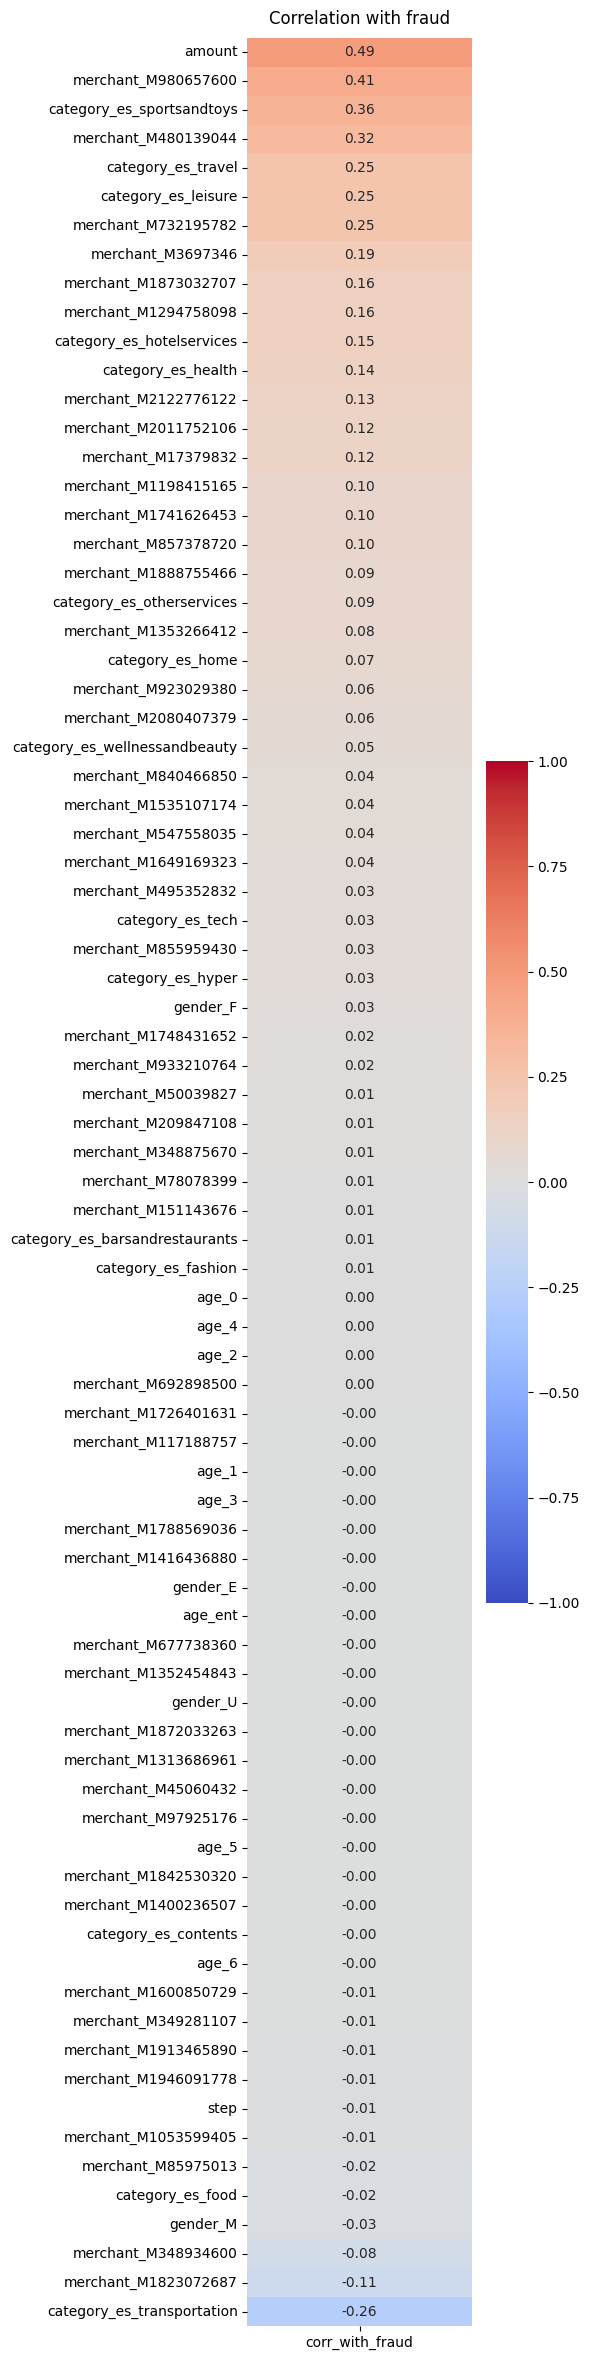

In [4]:
numeric_cols = df_basic.select_dtypes(include=[np.number]).columns
non_constant = [c for c in numeric_cols if df_basic[c].nunique() > 1]

corr = df_basic[non_constant].corr()['fraud'].drop(labels=['fraud'], errors='ignore').dropna()
corr_sorted = corr.sort_values(ascending=False)
corr_df = corr_sorted.to_frame(name='corr_with_fraud')

plt.figure(figsize=(6, max(4, len(corr_df) * 0.3)))
ax = sns.heatmap(
    corr_df,
    annot=True, fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1, center=0,
)
ax.set_title('Correlation with fraud', pad=10)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()


## Utilities: Temporal Split and Evaluation

- Temporal split using 80th percentile of `step`
- Drop non-feature identifiers (`customer`, `merchant`, `step`) per original code
- Common evaluation metrics helper


In [5]:
def make_features_and_target(df_in):
    X = df_in.drop(columns=['fraud'])
    y = df_in['fraud']
    return X, y


def temporal_train_test_split(X, y, step_col='step', percentile=80):
    X_sorted = X.sort_values(step_col)
    y_sorted = y.loc[X_sorted.index]
    step_threshold = np.percentile(X_sorted[step_col], percentile)
    train_idx = X_sorted[step_col] <= step_threshold
    test_idx = X_sorted[step_col] > step_threshold
    X_train_temp, X_test_temp = X_sorted[train_idx], X_sorted[test_idx]
    y_train_temp, y_test_temp = y_sorted[train_idx], y_sorted[test_idx]
    return X_train_temp, X_test_temp, y_train_temp, y_test_temp


def drop_non_feature_cols(X):
    drop_cols = [c for c in ['customer', 'merchant', 'step'] if c in X.columns]
    return X.drop(columns=drop_cols)


def evaluate(y_true, y_pred, y_proba):
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    print(f"F1: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return {
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
    }


# Prepare baseline X, y for initial models
X_basic, y_basic = make_features_and_target(df_basic)
Xtr_b, Xte_b, ytr_b, yte_b = temporal_train_test_split(X_basic, y_basic)
Xtr_b_feat = drop_non_feature_cols(Xtr_b)
Xte_b_feat = drop_non_feature_cols(Xte_b)

print('Train/Test shapes:', Xtr_b_feat.shape, Xte_b_feat.shape)


Train/Test shapes: (476005, 78) (118638, 78)


## Logistic Regression (Temporal Split)

- Baseline on encoded features
- Variant with SMOTE applied to training set only


In [6]:
# Logistic Regression - without SMOTE
logreg = LogisticRegression(random_state=42)
logreg.fit(Xtr_b_feat, ytr_b)

y_pred = logreg.predict(Xte_b_feat)
y_proba = logreg.predict_proba(Xte_b_feat)[:, 1]

print("\nTemporal Test Set Results (Logistic Regression):")
_ = evaluate(yte_b, y_pred, y_proba)



Temporal Test Set Results (Logistic Regression):
F1: 0.7821
ROC-AUC: 0.9980
PR-AUC: 0.9004
Precision: 0.9447
Recall: 0.6672


In [7]:
# Logistic Regression - with SMOTE
smote = SMOTE(random_state=42)
Xtr_sm, ytr_sm = smote.fit_resample(Xtr_b_feat, ytr_b)

logreg_sm = LogisticRegression(random_state=42)
logreg_sm.fit(Xtr_sm, ytr_sm)

y_pred_sm = logreg_sm.predict(Xte_b_feat)
y_proba_sm = logreg_sm.predict_proba(Xte_b_feat)[:, 1]

print("\nTemporal Test Set Results (Logistic Regression + SMOTE):")
_ = evaluate(yte_b, y_pred_sm, y_proba_sm)



Temporal Test Set Results (Logistic Regression + SMOTE):
F1: 0.5960
ROC-AUC: 0.9962
PR-AUC: 0.7932
Precision: 0.4422
Recall: 0.9141


## Random Forest (Temporal Split)

- Baseline on encoded features
- Variant with SMOTE applied to training set only


In [8]:
# Random Forest - without SMOTE
rf = RandomForestClassifier(random_state=42)
rf.fit(Xtr_b_feat, ytr_b)

y_pred = rf.predict(Xte_b_feat)
y_proba = rf.predict_proba(Xte_b_feat)[:, 1]

print("\nTemporal Test Set Results (Random Forest):")
_ = evaluate(yte_b, y_pred, y_proba)



Temporal Test Set Results (Random Forest):
F1: 0.7754
ROC-AUC: 0.9523
PR-AUC: 0.8447
Precision: 0.8397
Recall: 0.7203


In [9]:
# Random Forest - with SMOTE
smote = SMOTE(random_state=42)
Xtr_sm, ytr_sm = smote.fit_resample(Xtr_b_feat, ytr_b)

rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(Xtr_sm, ytr_sm)

y_pred_sm = rf_sm.predict(Xte_b_feat)
y_proba_sm = rf_sm.predict_proba(Xte_b_feat)[:, 1]

print("\nTemporal Test Set Results (Random Forest + SMOTE):")
_ = evaluate(yte_b, y_pred_sm, y_proba_sm)



Temporal Test Set Results (Random Forest + SMOTE):
F1: 0.7668
ROC-AUC: 0.9558
PR-AUC: 0.8089
Precision: 0.8177
Recall: 0.7219


## LightGBM (Temporal Split) — Baseline and SMOTE

- Train using encoded baseline features
- With and without SMOTE on training set


In [10]:
# LightGBM - baseline
lgb_params = {
    'random_state': 42,
}
train_data = lgb.Dataset(Xtr_b_feat, label=ytr_b)
model_lgb = lgb.train(lgb_params, train_data)

y_proba = model_lgb.predict(Xte_b_feat)
y_pred = (y_proba > 0.5).astype(int)

print("\nTemporal Test Set Results (LightGBM):")
_ = evaluate(yte_b, y_pred, y_proba)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 476005, number of used features: 76
[LightGBM] [Info] Start training from score 0.012437

Temporal Test Set Results (LightGBM):
F1: 0.8244
ROC-AUC: 0.9977
PR-AUC: 0.9219
Precision: 0.9320
Recall: 0.7391


In [11]:
# LightGBM - with SMOTE
smote = SMOTE(random_state=42)
Xtr_sm, ytr_sm = smote.fit_resample(Xtr_b_feat, ytr_b)

lgb_params = {
    'random_state': 42,
}
train_data_sm = lgb.Dataset(Xtr_sm, label=ytr_sm)
model_lgb_sm = lgb.train(lgb_params, train_data_sm)

y_proba_sm = model_lgb_sm.predict(Xte_b_feat)
y_pred_sm = (y_proba_sm > 0.5).astype(int)

print("\nTemporal Test Set Results (LightGBM + SMOTE):")
_ = evaluate(yte_b, y_pred_sm, y_proba_sm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 940170, number of used features: 77
[LightGBM] [Info] Start training from score 0.500000

Temporal Test Set Results (LightGBM + SMOTE):
F1: 0.8092
ROC-AUC: 0.9965
PR-AUC: 0.9000
Precision: 0.7365
Recall: 0.8977


## Feature Engineering

- Derive `hour_of_day`, `day_of_week`
- Log-transform `amount` with `log1p`
- Sort by `customer` and `step` for sequential features
- Cumulative features per customer: transaction count, average spend, std spend, previous fraud indicator
- Rolling 24-hour features per customer: transaction count and amount sum


In [12]:
df_adv = df_basic.copy()

# Temporal features
if 'step' in df_adv.columns:
    df_adv['hour_of_day'] = df_adv['step'] % 24
    df_adv['day_of_week'] = (df_adv['step'] // 24) % 7

# Log-transform amount
if 'amount' in df_adv.columns:
    df_adv['amount'] = np.log1p(df_adv['amount'])

# Sort for sequential features
sort_cols = [c for c in ['customer', 'step'] if c in df_adv.columns]
df_adv = df_adv.sort_values(sort_cols).reset_index(drop=True)

# Cumulative per-customer features
if 'customer' in df_adv.columns:
    df_adv['cust_txn_count'] = df_adv.groupby('customer').cumcount()

    df_adv['cust_avg_spend'] = (
        df_adv.groupby('customer')['amount']
        .transform(lambda x: x.shift().expanding().mean())
        .fillna(0)
    )

    df_adv['cust_std_spend'] = (
        df_adv.groupby('customer')['amount']
        .transform(lambda x: x.shift().expanding().std())
        .fillna(0)
    )

    if 'fraud' in df_adv.columns:
        df_adv['cust_prev_fraud'] = (
            df_adv.groupby('customer')['fraud']
            .transform(lambda x: x.shift().fillna(0).cumsum().clip(upper=1))
            .fillna(0)
            .astype(int)
        )

# Rolling 24h features per customer
if set(['customer', 'step']).issubset(df_adv.columns):
    df_adv['txn_count_24h'] = 0
    df_adv['amount_sum_24h'] = 0.0

    def rolling_24h_features(group):
        steps = group['step'].values
        amounts = group['amount'].values
        txn_count_24h = []
        amount_sum_24h = []
        left = 0
        for right in range(len(steps)):
            while steps[right] - steps[left] > 23:
                left += 1
            txn_count_24h.append(right - left)
            amount_sum_24h.append(amounts[left:right].sum() if right > left else 0.0)
        group['txn_count_24h'] = txn_count_24h
        group['amount_sum_24h'] = amount_sum_24h
        return group

    df_adv = df_adv.groupby('customer', group_keys=False).apply(rolling_24h_features)

print('df_adv shape:', df_adv.shape)
df_adv.head()


df_adv shape: (594643, 90)


,step,customer,merchant,amount,fraud,age_0,age_1,age_2,age_3,age_4,...,merchant_M97925176,merchant_M980657600,hour_of_day,day_of_week,cust_txn_count,cust_avg_spend,cust_std_spend,cust_prev_fraud,txn_count_24h,amount_sum_24h
0,30,C1000148617,M1888755466,4.975837,0,0,0,0,0,0,...,0,0,6,1,0,0.000000,0.000000,0,0,0.000000
1,38,C1000148617,M1741626453,2.873000,0,0,0,0,0,0,...,0,0,14,1,1,4.975837,0.000000,0,1,4.975837
2,42,C1000148617,M1888755466,4.046204,0,0,0,0,0,0,...,0,0,18,1,2,3.924418,1.486931,0,2,7.848836
3,43,C1000148617,M840466850,2.756205,0,0,0,0,0,0,...,0,0,19,1,3,3.965013,1.053767,0,3,11.895040
4,44,C1000148617,M1823072687,3.879913,0,0,0,0,0,0,...,0,0,20,1,4,3.662811,1.051469,0,4,14.651246


## Merchant Aggregates + LightGBM

- Build merchant-level transaction count and fraud rate on training split only
- Map aggregates to train/test splits (unseen merchants get global defaults)
- Train LightGBM after feature engineering


In [13]:
# Prepare advanced feature set splits
X_adv, y_adv = make_features_and_target(df_adv)
Xtr_a, Xte_a, ytr_a, yte_a = temporal_train_test_split(X_adv, y_adv)

# Build merchant aggregates on train only
merchant_stats = Xtr_a[['merchant']].copy()
merchant_stats['fraud'] = ytr_a.values
merchant_agg = merchant_stats.groupby('merchant').agg(
    merchant_txn_count=('fraud', 'count'),
    merchant_fraud_rate=('fraud', 'mean')
).reset_index()

# Merge aggregates
Xtr_aug = Xtr_a.merge(merchant_agg, on='merchant', how='left')
Xte_aug = Xte_a.merge(merchant_agg, on='merchant', how='left')

# Fill unseen merchants with global defaults
global_txn_count = 0
global_fraud_rate = 0.0
for col, default in [('merchant_txn_count', global_txn_count), ('merchant_fraud_rate', global_fraud_rate)]:
    Xtr_aug[col] = Xtr_aug[col].fillna(default)
    Xte_aug[col] = Xte_aug[col].fillna(default)

# Drop non-feature columns
Xtr_aug_feat = drop_non_feature_cols(Xtr_aug)
Xte_aug_feat = drop_non_feature_cols(Xte_aug)

# Train LightGBM on augmented features
clf_aug = lgb.LGBMClassifier(random_state=42)
clf_aug.fit(Xtr_aug_feat, ytr_a)

y_pred = clf_aug.predict(Xte_aug_feat)
y_proba = clf_aug.predict_proba(Xte_aug_feat)[:, 1]

print("\nTemporal Test Set Results (LightGBM + Merchant Aggregates):")
_ = evaluate(yte_a, y_pred, y_proba)


[LightGBM] [Info] Number of positive: 5920, number of negative: 470085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 476005, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012437 -> initscore=-4.374577
[LightGBM] [Info] Start training from score -4.374577

Temporal Test Set Results (LightGBM + Merchant Aggregates):
F1: 0.8793
ROC-AUC: 0.9992
PR-AUC: 0.9426
Precision: 0.9063
Recall: 0.8539


## LightGBM Hyperparameter Tuning (Random Search)

- Split train into train/validation for tuning
- Randomized parameter sampling
- Select best by validation PR-AUC
- Retrain on full training data with best params


In [14]:
# Train/Val split for tuning
Xtr_sub, Xval_sub, ytr_sub, yval_sub = train_test_split(
    Xtr_aug_feat, ytr_a, test_size=0.2, random_state=42, stratify=ytr_a
)

best_score = -np.inf
best_params = None
best_model = None

rng = np.random.default_rng(42)
param_space = {
    'learning_rate': [0.02, 0.03, 0.05, 0.07, 0.1],
    'num_leaves': [31, 63, 95, 127, 191],
    'max_depth': [-1, 6, 8, 10],
    'min_data_in_leaf': [50, 100, 200, 400],
    'feature_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 5],
    'lambda_l1': [0.0, 0.1, 1.0, 5.0],
    'lambda_l2': [0.0, 0.1, 1.0, 5.0],
}

n_iter = 20
for i in range(n_iter):
    params = {
        'learning_rate': float(rng.choice(param_space['learning_rate'])),
        'num_leaves': int(rng.choice(param_space['num_leaves'])),
        'max_depth': int(rng.choice(param_space['max_depth'])),
        'min_data_in_leaf': int(rng.choice(param_space['min_data_in_leaf'])),
        'feature_fraction': float(rng.choice(param_space['feature_fraction'])),
        'bagging_fraction': float(rng.choice(param_space['bagging_fraction'])),
        'bagging_freq': int(rng.choice(param_space['bagging_freq'])),
        'lambda_l1': float(rng.choice(param_space['lambda_l1'])),
        'lambda_l2': float(rng.choice(param_space['lambda_l2'])),
        'random_state': 42,
        'n_estimators': 1000,
        'n_jobs': -1,
    }
    clf = lgb.LGBMClassifier(**params)
    clf.fit(
        Xtr_sub, ytr_sub,
        eval_set=[(Xval_sub, yval_sub)],
        eval_metric='average_precision',
    )
    val_pred_proba = clf.predict_proba(Xval_sub)[:, 1]
    val_pr_auc = average_precision_score(yval_sub, val_pred_proba)
    if val_pr_auc > best_score:
        best_score = val_pr_auc
        best_params = params
        best_model = clf

print('Best hyperparameters found:')
for k, v in best_params.items():
    print(f'  {k}: {v}')
print(f'Best validation PR-AUC: {best_score:.4f}')

# Retrain on full training set with best params
final_clf = lgb.LGBMClassifier(**best_params)
final_clf.fit(
    Xtr_aug_feat, ytr_a,
    eval_set=[(Xval_sub, yval_sub)],
    eval_metric='average_precision',
)

y_pred = final_clf.predict(Xte_aug_feat)
y_proba = final_clf.predict_proba(Xte_aug_feat)[:, 1]

print("\nTemporal Test Set Results (LightGBM Tuned + Merchant Aggregates):")
metrics_final = evaluate(yte_a, y_pred, y_proba)


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[Ligh

## Evaluation: Confusion Matrix (Tuned Model)

- Plot confusion matrix for tuned LightGBM on temporal test set


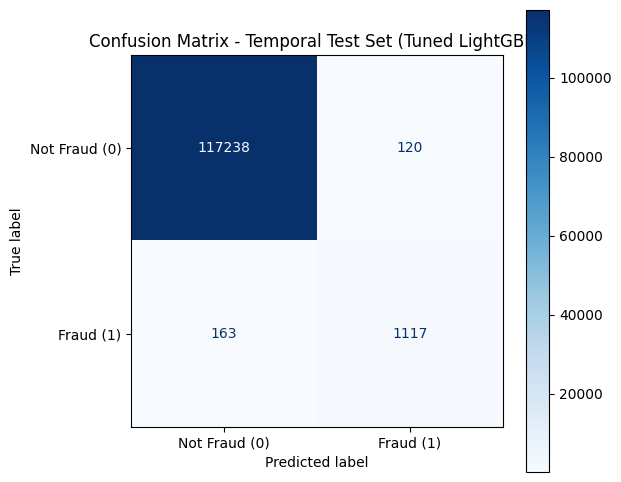

In [15]:
cm = confusion_matrix(yte_a, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud (0)', 'Fraud (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix - Temporal Test Set (Tuned LightGBM)')
plt.show()


## Explainability: SHAP Plots (Top 10 Features)

- SHAP TreeExplainer on tuned LightGBM
- Beeswarm and bar plots for top 10 features



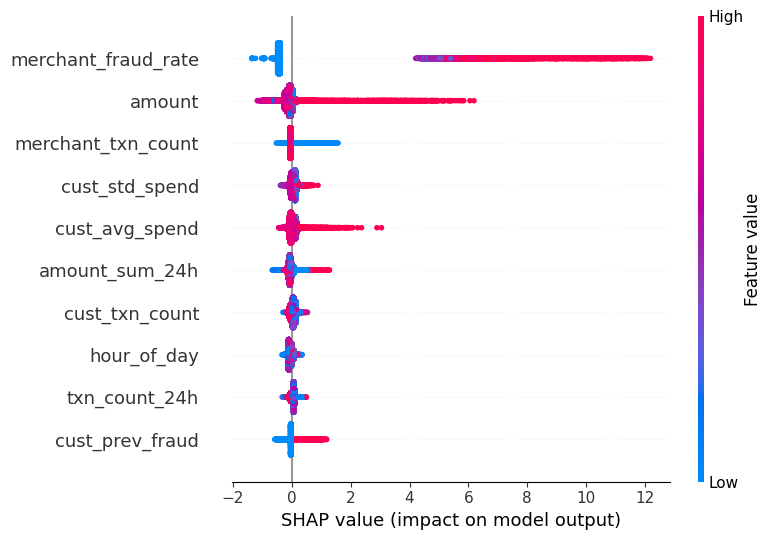

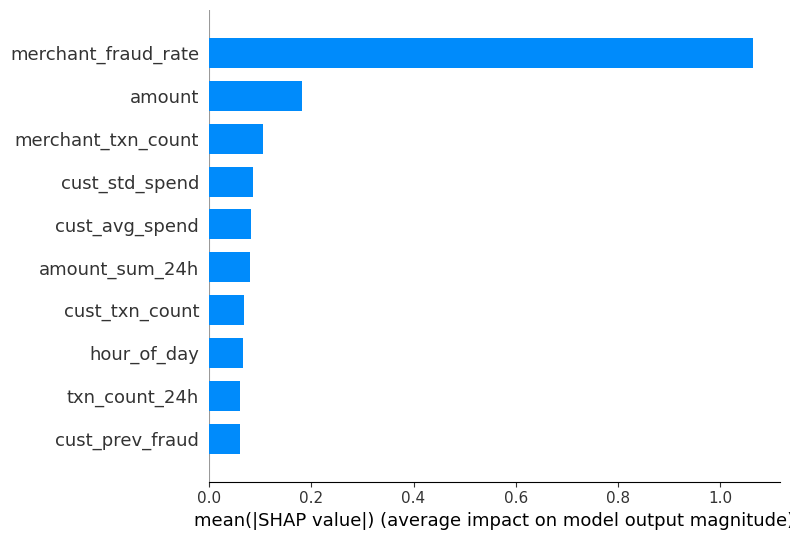

In [16]:
explainer = shap.TreeExplainer(final_clf)
# Use a subset for speed if needed
subset = Xtr_aug_feat.iloc[:50000]
shap_values = explainer.shap_values(subset)

# Beeswarm plot
shap.summary_plot(
    shap_values,
    subset,
    plot_type='dot',
    show=True,
    max_display=10,
)

# Bar plot
shap.summary_plot(
    shap_values,
    subset,
    plot_type='bar',
    show=True,
    max_display=10,
)


## Save Final Model

- Persist tuned LightGBM to `model.joblib`


In [17]:
joblib.dump(final_clf, 'models/model.joblib')
print('Saved model to models/model.joblib')

Saved model to models/model.joblib
